In [1]:
from keras.models import load_model
from keras.engine.topology import Layer
from keras import backend as K

Using TensorFlow backend.


In [2]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(** kwargs)

    def build(self, input_shape):
        assert len(input_shape)==3
        # W.shape = (time_steps, time_steps)
        self.W = self.add_weight(name='att_weight', 
                                 shape=(input_shape[1], input_shape[1]),
                                 initializer='uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias', 
                                 shape=(input_shape[1],),
                                 initializer='uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs.shape = (batch_size, time_steps, seq_len)
        x = K.permute_dimensions(inputs, (0, 2, 1))
        # x.shape = (batch_size, seq_len, time_steps)
        a = K.softmax(K.tanh(K.dot(x, self.W) + self.b))
        outputs = K.permute_dimensions(a * x, (0, 2, 1))
#         outputs = K.sum(outputs, axis=1)
        return outputs

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], input_shape[2]

In [3]:
model = load_model('encoder_decoder_gru_python_data.h5', custom_objects={'AttentionLayer': AttentionLayer})

In [4]:
from sklearn.externals import joblib
import scipy.io as sio
stdsc = joblib.load('stdsc.m')
matfn = u'C:\\Users\\XR\\Desktop\\论文python程序\\Q1.mat'
matfn2 = u'C:\\Users\\XR\\Desktop\\论文python程序\\M1.mat'
data = sio.loadmat(matfn)
data2 = sio.loadmat(matfn2)
P = data['Q1'].T
P = stdsc.transform(data['Q1'].T)
P = P.reshape((235200, 1, 60))
T = data2['dataTrdM'].reshape((235200, 1, 1))
P_train = P[:180000, :, :]
T_train = T[:180000, :, :]
P_test = P[180000:, :, :]
T_test = T[180000:, :, :]
print(P_test.shape)

(55200, 1, 60)


In [5]:
import numpy as np
T2 = data2['dataTrdM']
T2 = [x[0] for x in T2]
T_new = []
for i in range(1600):
    tmp = [0] * 10
    tmp.extend(T2[i * 147: (i + 1)* 147 - 1])
    for j in range(len(tmp) - 9):
        T_new.append(tmp[j: j + 10])
T_new = np.array(T_new)
T_new_Train = T_new[:180000, :]
T_new_Test = T_new[180000:, :]
T_new_Train = T_new_Train.reshape(180000,1,10)
T_new_Test = T_new_Test.reshape(55200,1,10)
print(T_new_Train.shape)

(180000, 1, 10)


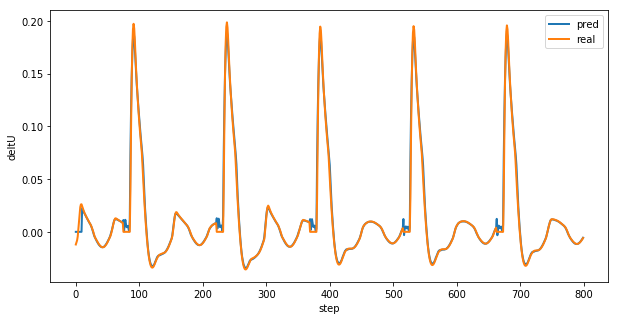

In [6]:
import matplotlib.pyplot as plt
pred = []
real = []
for i in range(0, 800):
    if i <= 9:
        pred.append(0)
        real.append(T_test[i])
    else:
        PredarrayP = P_test[i,0,:].reshape(1,1,60)
        PredarrayT = T_new_Test[i,0,:].reshape(1,1,10)
        predNum = model.predict([PredarrayP, PredarrayT])
        pred.append(predNum)
        real.append(T_test[i,0,0])
plt.figure(figsize=(10,5))
plt.plot(pred, linewidth=2, label='pred')
plt.plot(real, linewidth=2, label='real')
plt.xlabel('step')
plt.ylabel('deltU')
plt.legend()
plt.show()